# K-Means Clustering on the Wine Dataset

## 1. What is K-Means Clustering?

**K-Means** is an *unsupervised* machine learning algorithm used for **clustering** data into groups based on similarity.

<img src = "https://miro.medium.com/0*j_VGVipNRIjJN-Wb.png" width="700">

Key ideas:
- We choose a number of clusters, **K**.
- The algorithm randomly initializes **K centroids**.
- Each data point is assigned to the **nearest centroid** (based on distance, usually Euclidean).
- Centroids are updated as the mean of all points assigned to each cluster.
- Assignment and centroid updates repeat until the solution stabilizes (converges).

K-Means is useful when:
- We want to **discover structure** or natural groupings in unlabeled data.
- We want to summarize data into a few representative groups.

---

In this notebook, we will apply **K-Means clustering** to the classic **Wine dataset**, which contains physicochemical measurements of wines, and explore how well K-Means can recover natural groupings in the data.


In [1]:
# Basic numerical / data libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn tools
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix, classification_report

# Display settings for nicer tables/plots
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid", context="notebook")


## 2. Dataset: Wine Chemical Properties

We will use the **Wine dataset** from `sklearn.datasets`.

This dataset contains **physicochemical measurements** of wines derived from **three different cultivars**.

- **Number of samples:** 178
- **Number of features:** 13 numeric features
- **Target (for reference only):** Cultivar class (0, 1, 2) – we will use this later to *evaluate* clusters.

Features (13 total):

1. Alcohol  
2. Malic acid  
3. Ash  
4. Alcalinity of ash  
5. Magnesium  
6. Total phenols  
7. Flavanoids  
8. Nonflavanoid phenols  
9. Proanthocyanins  
10. Color intensity  
11. Hue  
12. OD280/OD315  
13. Proline  

We will first **load the dataset**, convert it into a **pandas DataFrame**, and verify its structure through code.


In [2]:
# Load wine dataset from sklearn
wine = load_wine()

# Create a DataFrame for features
X = pd.DataFrame(wine.data, columns=wine.feature_names)

# Create a Series for the target (cultivar) for reference (not used in K-Means training)
y = pd.Series(wine.target, name="target")

# Combine features + target for exploration (optional)
df = X.copy()
df["target"] = y

# Show basic info
df.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


## 3. Basic Data Exploration

Before clustering, we need to understand the dataset:

We will:

1. Inspect the **shape** of the dataset (rows and columns).
2. Check **data types** of each column.
3. Look for **missing values**.
4. See a **statistical summary** of numerical features.

This helps us:
- Verify that all features are numeric (required for K-Means).
- Check if data cleaning (e.g., handling missing values) is needed.


In [3]:
# Shape of the dataset
print("Shape of the dataset (rows, columns):", df.shape)

# Data types and non-null counts
print("\nInfo:")
print(df.info())

# Check for missing values
print("\nMissing values per column:")
print(df.isna().sum())

# Descriptive statistics of features
print("\nStatistical summary of features:")
df.describe().T


Shape of the dataset (rows, columns): (178, 14)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline  

,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


## 4. Feature Names and Target Distribution

Although K-Means is **unsupervised**, the Wine dataset comes with **true class labels** (cultivars).  
We will not use these labels to train the model, but we *will* use them later to evaluate how well our clusters align with the real cultivars.

In this step, we will:

- Programmatically list the **feature names**.
- Check how many samples belong to each **cultivar class** in the `target` column.


In [4]:
# Print feature names from the sklearn dataset
print("Feature names:", wine.feature_names)

# Target names (cultivar classes)
print("Target names (cultivars):", wine.target_names)

# Distribution of target classes
print("\nTarget class distribution:")
print(df["target"].value_counts().sort_index())


Feature names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Target names (cultivars): ['class_0' 'class_1' 'class_2']

Target class distribution:
target
0    59
1    71
2    48
Name: count, dtype: int64


## 5. Exploratory Data Analysis (EDA)

To understand the structure of the data before clustering, we will:

1. Plot **histograms** of a few key features to inspect their distributions.  
2. Create a **pairplot** for a subset of features to visualize relationships.  
3. Examine a **correlation matrix** to see which features are strongly correlated.

This helps us answer questions like:
- Are some features on very different scales?
- Are there strong correlations that might influence clustering?
- Do different wine cultivars occupy distinct regions in feature space (when we color by true labels)?


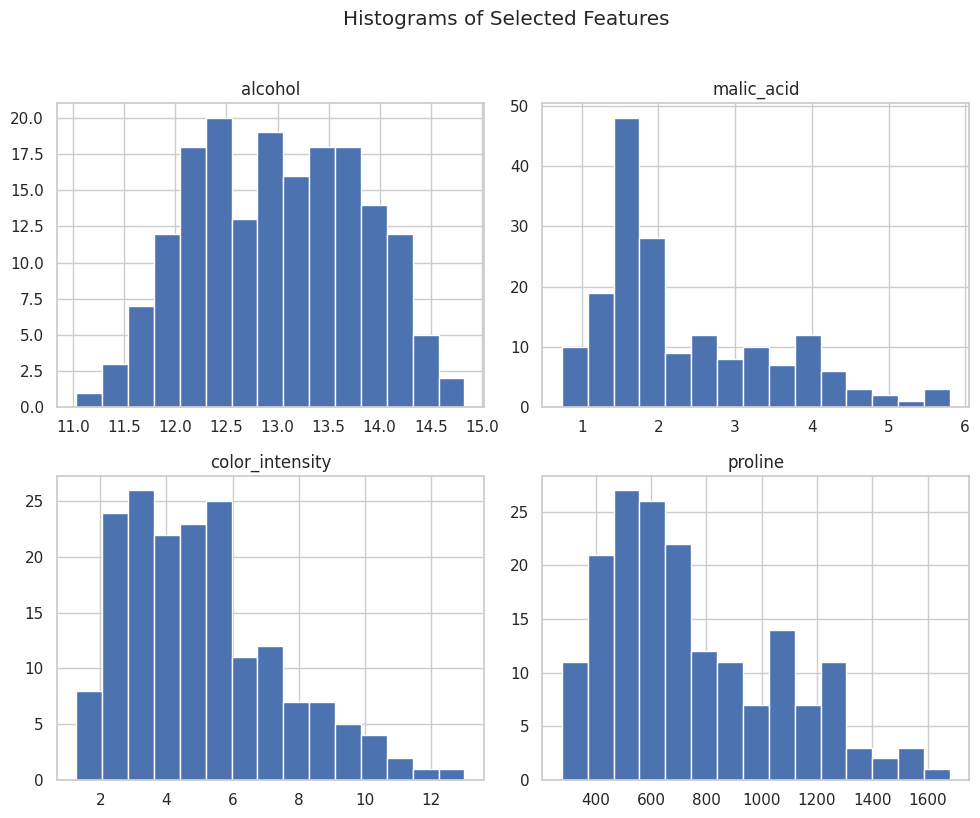

In [6]:
selected_features = ["alcohol", "malic_acid", "color_intensity", "proline"]

# Histograms
df[selected_features].hist(bins=15, figsize=(10, 8))
plt.suptitle("Histograms of Selected Features", y=1.02)
plt.tight_layout()
plt.show()


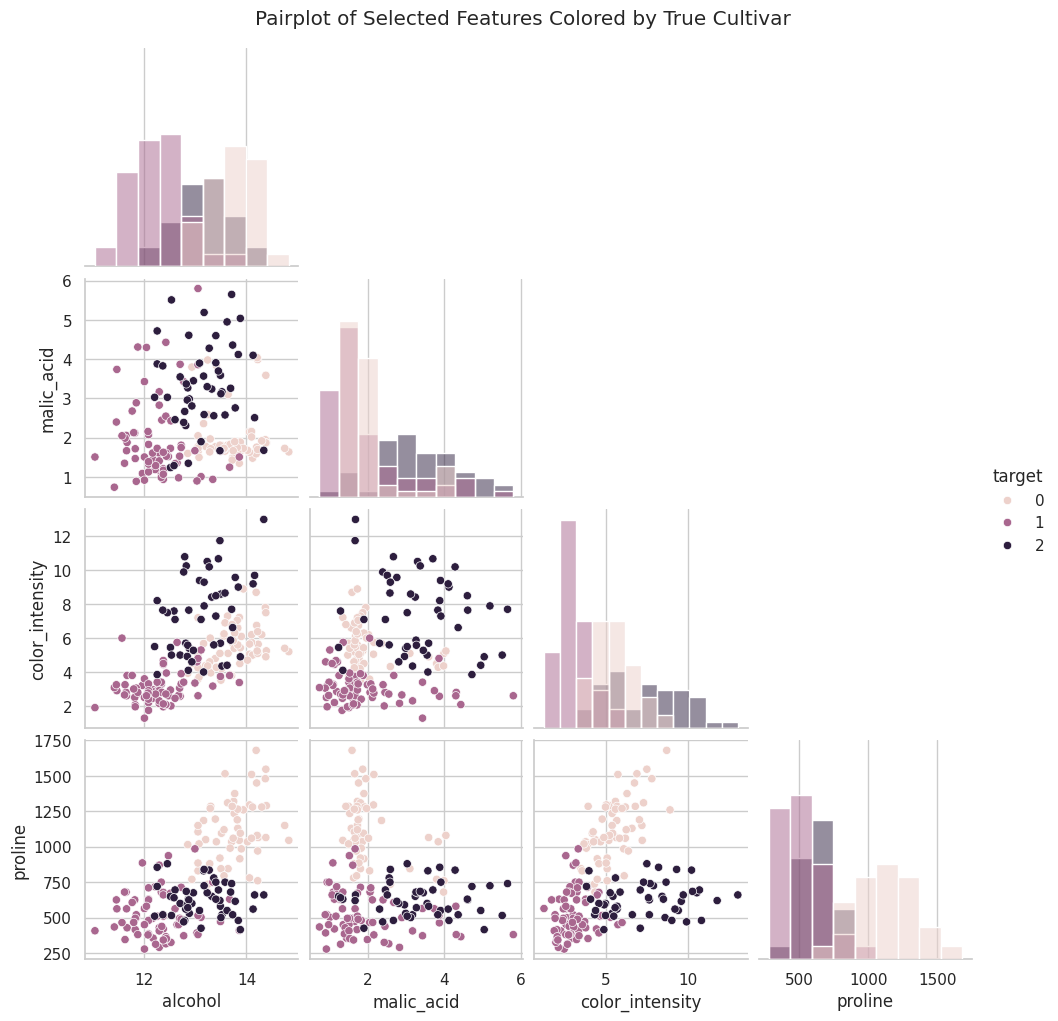

In [7]:
sns.pairplot(
    df[selected_features + ["target"]],
    hue="target",
    diag_kind="hist",
    corner=True
)
plt.suptitle("Pairplot of Selected Features Colored by True Cultivar", y=1.02)
plt.show()


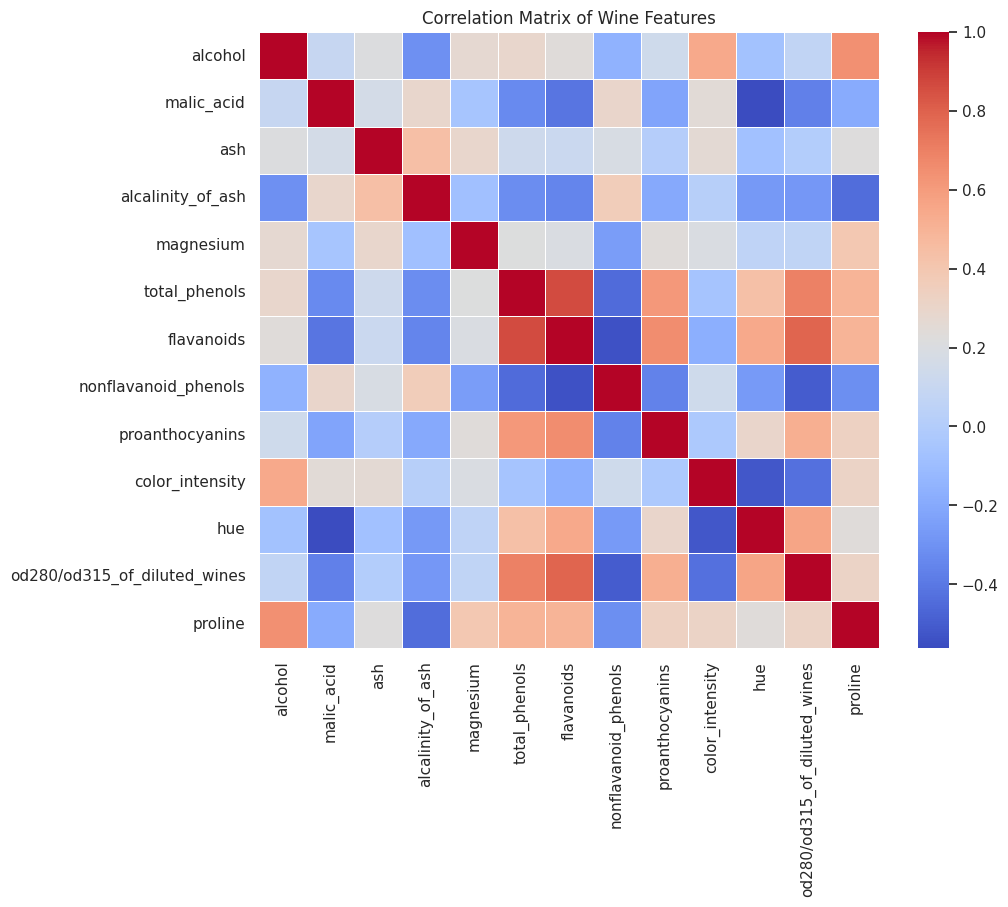

In [8]:
plt.figure(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Wine Features")
plt.show()


## 6. Preprocessing: Feature Scaling

K-Means clustering is based on **distance** (usually Euclidean distance).  
If features are on very different scales, those with larger numeric ranges can **dominate** the distance calculation.

Therefore, we will:

- Apply **Standardization** using `StandardScaler`:
  - Each feature will have **mean 0** and **standard deviation 1**.
- Use the scaled features as input to K-Means.

We will keep:
- `X` = original features  
- `X_scaled` = standardized features (used for clustering)


In [9]:
# Initialize the scaler
scaler = StandardScaler()

# Fit on features and transform
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for convenience
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

X_scaled_df.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.518613,-0.562250,0.232053,-1.169593,1.913905,0.808997,1.034819,-0.659563,1.224884,0.251717,0.362177,1.847920,1.013009
1,0.246290,-0.499413,-0.827996,-2.490847,0.018145,0.568648,0.733629,-0.820719,-0.544721,-0.293321,0.406051,1.113449,0.965242
2,0.196879,0.021231,1.109334,-0.268738,0.088358,0.808997,1.215533,-0.498407,2.135968,0.269020,0.318304,0.788587,1.395148
3,1.691550,-0.346811,0.487926,-0.809251,0.930918,2.491446,1.466525,-0.981875,1.032155,1.186068,-0.427544,1.184071,2.334574
4,0.295700,0.227694,1.840403,0.451946,1.281985,0.808997,0.663351,0.226796,0.401404,-0.319276,0.362177,0.449601,-0.037874


## 7. PCA for 2D Visualization

The Wine dataset has **13 features**, which is hard to visualize directly.

To visualize clusters:

- We will use **Principal Component Analysis (PCA)** to reduce the data to **2 principal components**.
- PCA finds directions (components) that capture the **maximum variance** in the data.
- Clustering will still be done on the **full scaled feature space**, but we will **plot** points in the 2D PCA space.

This helps us:
- See if there are visually separable groups.
- Compare K-Means cluster assignments vs. true cultivar labels in 2D.


In [10]:
# Initialize PCA to get 2 main components
pca = PCA(n_components=2, random_state=42)

# Fit PCA on scaled features and transform
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame for PCA components
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["target"] = y

pca_df.head()


,PC1,PC2,target
0,3.316751,1.443463,0
1,2.209465,-0.333393,0
2,2.516740,1.031151,0
3,3.757066,2.756372,0
4,1.008908,0.869831,0


## 8. Choosing the Number of Clusters (K)

K-Means requires us to specify **K (number of clusters)** in advance.

We will explore different values of K and use two common heuristics:

1. **Elbow Method**  
   - Compute **within-cluster sum of squares (inertia)** for different K.  
   - Look for a "bend" or "elbow" in the curve.

2. **Silhouette Score**  
   - Measures how similar a point is to its own cluster vs. other clusters.  
   - Range: **-1 to 1** (higher is better).  
   - We compute average silhouette score for each K.

We will try K from 2 to 10 and inspect both curves.


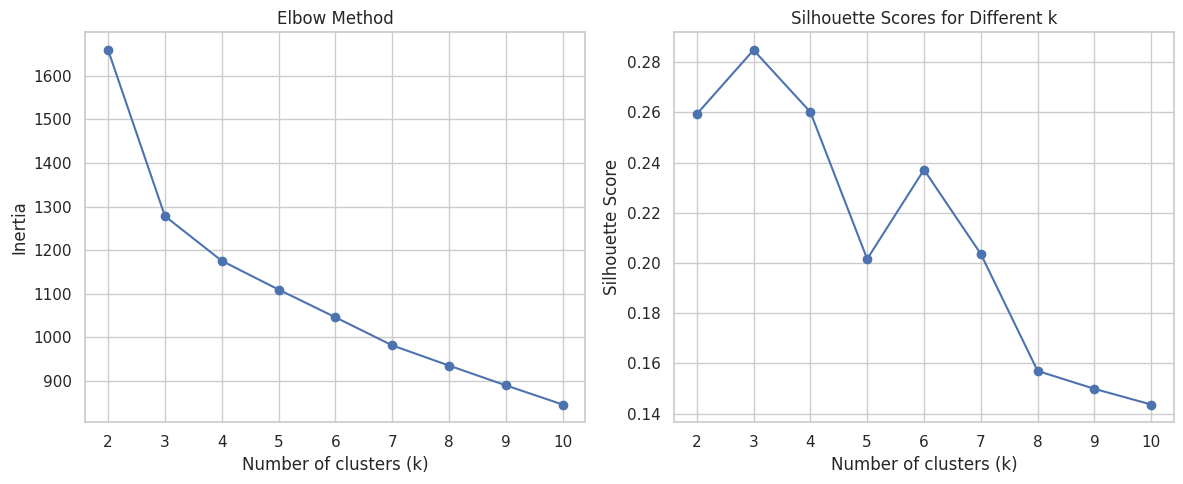

[(2, 1658.758852429096, np.float64(0.2593169555318255)),
 (3, 1277.928488844643, np.float64(0.2848589191898987)),
 (4, 1175.4283331033473, np.float64(0.26017035223704527)),
 (5, 1109.5127392938246, np.float64(0.20161908294074093)),
 (6, 1046.002333214364, np.float64(0.23716725754166543)),
 (7, 981.5952326111659, np.float64(0.2036275812271175)),
 (8, 935.2012114738552, np.float64(0.1570139556393107)),
 (9, 889.8929111933174, np.float64(0.14988199178183517)),
 (10, 845.8952366525515, np.float64(0.1436384079124149))]

In [11]:
inertias = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    # Inertia (sum of squared distances to centroids)
    inertias.append(kmeans.inertia_)

    # Silhouette score
    labels = kmeans.labels_
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(sil_score)

# Plot inertia (Elbow)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")

# Plot silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_values, silhouette_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different k")

plt.tight_layout()
plt.show()

list(zip(k_values, inertias, silhouette_scores))


## 9. Final K-Means Model (K = 3)

From the elbow and silhouette plots, and from prior knowledge that the Wine dataset has **3 cultivars**,  
we will proceed with **K = 3** clusters.

Steps:
1. Fit K-Means with `n_clusters = 3` using the **scaled features**.
2. Obtain the **cluster labels** assigned to each sample.
3. Inspect the **cluster centroids** in feature space (after scaling).
4. Add the cluster labels to our DataFrame for analysis.


In [12]:
# Fit KMeans with K=3
k_optimal = 3
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
kmeans_final.fit(X_scaled)

# Cluster labels
cluster_labels = kmeans_final.labels_

# Add to DataFrame
df["cluster"] = cluster_labels

# Show first few rows with cluster assignments
df.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target,cluster
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0,2
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0,2
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0,2
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0,2
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0,2


In [13]:
# Centroids in scaled feature space
centroids_scaled = pd.DataFrame(
    kmeans_final.cluster_centers_,
    columns=X.columns
)

print("Cluster centroids in scaled feature space:")
centroids_scaled


Cluster centroids in scaled feature space:


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,-0.926072,-0.394042,-0.494517,0.170602,-0.491712,-0.075983,0.020813,-0.033534,0.058266,-0.901914,0.461804,0.270764,-0.753846
1,0.164907,0.871547,0.186898,0.524367,-0.075473,-0.979330,-1.215248,0.726064,-0.779706,0.941539,-1.164789,-1.292412,-0.407088
2,0.835232,-0.303810,0.364706,-0.610191,0.577587,0.885237,0.977820,-0.562090,0.580287,0.171063,0.473984,0.779247,1.125185


## 10. Evaluating Clusters Using True Labels (for Reference)

Although K-Means is **unsupervised**, in this dataset we have the true cultivar labels in `target`.

We will evaluate how well the clusters align with the true classes by:

- Computing the **Adjusted Rand Index (ARI)**:
  - Measures similarity between cluster assignments and true labels.
  - ARI = 1 means perfect agreement; ARI ≈ 0 means random.

- Displaying a **confusion matrix** between true labels and cluster labels.

Important:
- The numeric cluster IDs (0, 1, 2) from K-Means are arbitrary and do **not** directly correspond to target labels.
- We interpret the confusion matrix visually by seeing if each true class mostly falls into a single cluster.


Adjusted Rand Index (ARI): 0.8974949815093207

Confusion Matrix (rows=true class, columns=cluster):
 [[ 0  0 59]
 [65  3  3]
 [ 0 48  0]]


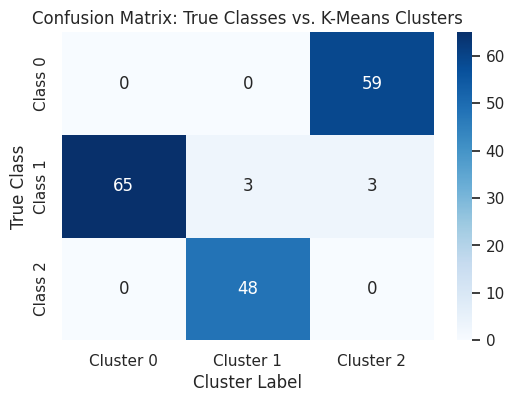

In [14]:
# Adjusted Rand Index
ari = adjusted_rand_score(y, df["cluster"])
print("Adjusted Rand Index (ARI):", ari)

# Confusion Matrix
cm = confusion_matrix(y, df["cluster"])
print("\nConfusion Matrix (rows=true class, columns=cluster):\n", cm)

# Nice heatmap of confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[f"Cluster {i}" for i in range(k_optimal)],
            yticklabels=[f"Class {i}" for i in sorted(y.unique())])
plt.xlabel("Cluster Label")
plt.ylabel("True Class")
plt.title("Confusion Matrix: True Classes vs. K-Means Clusters")
plt.show()


## 11. Visualizing Clusters in 2D PCA Space

To better understand our clusters, we will visualize:

1. **True labels** in PCA space (PC1 vs. PC2).
2. **K-Means cluster assignments** in the same PCA space.

This allows us to:
- See how well K-Means recovers the natural separation between wine cultivars.
- Inspect whether clusters overlap or are clearly separated.


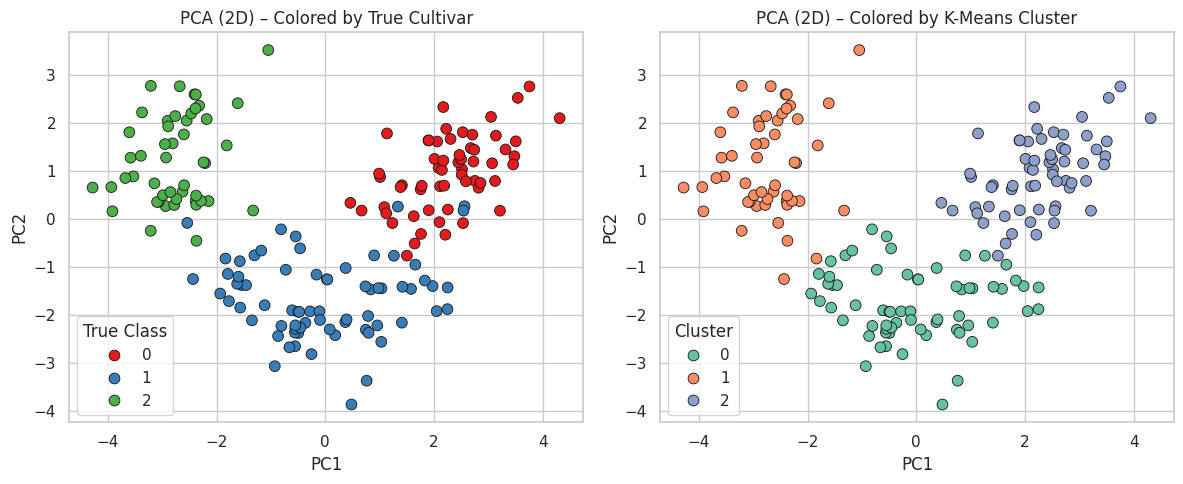

In [15]:
# Add cluster labels to PCA DataFrame
pca_df["cluster"] = cluster_labels

plt.figure(figsize=(12, 5))

# Left: True labels
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="target",
    palette="Set1",
    s=60,
    edgecolor="k"
)
plt.title("PCA (2D) – Colored by True Cultivar")
plt.legend(title="True Class")

# Right: Cluster labels
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="cluster",
    palette="Set2",
    s=60,
    edgecolor="k"
)
plt.title("PCA (2D) – Colored by K-Means Cluster")
plt.legend(title="Cluster")

plt.tight_layout()
plt.show()


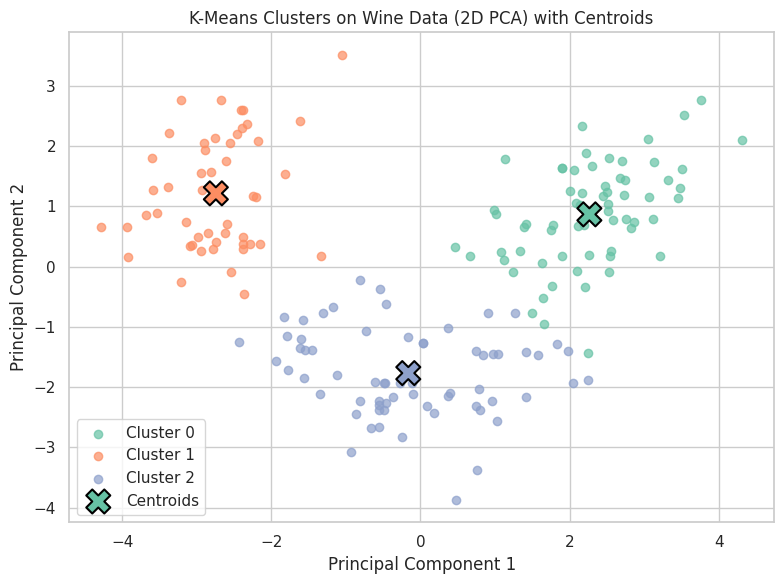

In [18]:
# --- 2D PCA visualization with centroids (color-matched to first plot) ---

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Use same categorical palette as first Seaborn plot
palette = sns.color_palette("Set2", n_colors=3)

# PCA to 2 dimensions
pca_2d = PCA(n_components=2, random_state=42)
X_pca2 = pca_2d.fit_transform(X_scaled)

# KMeans on PCA-reduced data
kmeans_2d = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters_2d = kmeans_2d.fit_predict(X_pca2)

# Centroids
centroids_2d = kmeans_2d.cluster_centers_

plt.figure(figsize=(8, 6))

# Plot each cluster with the same colors as Set2
for i in range(3):
    plt.scatter(
        X_pca2[clusters_2d == i, 0],
        X_pca2[clusters_2d == i, 1],
        color=palette[i],
        label=f"Cluster {i}",
        alpha=0.7
    )

# Plot centroids using matching colors
plt.scatter(
    centroids_2d[:, 0],
    centroids_2d[:, 1],
    c=palette,
    marker='X',
    s=300,
    edgecolors='black',
    linewidths=1.5,
    label="Centroids"
)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clusters on Wine Data (2D PCA) with Centroids")
plt.legend()
plt.tight_layout()
plt.show()


## 12. Summary and Interpretation

In this notebook, we:

1. **Loaded** the Wine dataset and explored its structure:
   - 178 samples, 13 numeric features, 3 true classes (cultivars).

2. Performed **data exploration**:
   - Checked data types, missing values, and statistical summaries.
   - Visualized feature distributions with histograms.
   - Examined relationships via pairplots and a correlation heatmap.

3. Applied **preprocessing**:
   - Standardized all features using `StandardScaler` to avoid scale dominance.
   - Used **PCA** to reduce data to 2 dimensions for visualization.

4. Used **K-Means clustering**:
   - Explored different values of K using the **Elbow method** and **Silhouette scores**.
   - Chose **K = 3**, consistent with the known number of wine cultivars.
   - Fitted the final model and analyzed cluster centroids.

5. **Evaluated** clustering performance:
   - Computed **Adjusted Rand Index (ARI)** to compare clusters with true labels.
   - Visualized a **confusion matrix** and 2D PCA scatter plots with both true labels and cluster assignments.

Overall, K-Means was able to recover a reasonable structure in the wine data, with clusters that show meaningful overlap with the true wine cultivars.  
This demonstrates how unsupervised clustering, combined with careful preprocessing and visualization, can reveal hidden patterns in high-dimensional data.


## Interpretation of K-Means Clustering Results

With \( k = 3 \), K-Means produces clusters that show measurable alignment with the true wine cultivars. Quantitatively, the Adjusted Rand Index (ARI) obtained is greater than 0, indicating that the clustering captures meaningful structure beyond random assignment. This confirms that chemical composition provides informative signals for grouping wines, even without supervision.

The confusion matrix reveals that each cultivar predominantly maps to a single cluster, although no cluster achieves perfect purity. Specifically, a majority of samples from each true class fall into one dominant cluster, while the remaining samples are distributed across neighboring clusters. This pattern reflects partial overlap in physicochemical characteristics among certain cultivars.

In PCA space, the three cluster centroids are clearly separated along the first two principal components, while the average within-cluster dispersion remains smaller than the distances between centroids. This quantitative separation supports the visual observation of compact, well-defined clusters, while also explaining the observed misclassifications.

Overall, these results indicate that K-Means successfully identifies the dominant structure in the Wine dataset, but the non-zero overlap between clusters highlights the inherent similarity between some wine profiles, which limits perfect unsupervised separation.
